In [1]:
import numpy as np
import pandas as pd
import os

import torch
from torchvision import transforms, datasets, models
from torch.utils.data.dataset import Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from torch import optim, cuda

import matplotlib.pyplot as plt
from skimage import io, transform

plt.ion()

from timeit import default_timer as timer
from sklearn.model_selection import train_test_split

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\ASUS\anaconda3\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


# variables

In [2]:
save_file_name = 'efficientnet-transfer-1.pt'
checkpoint_path = 'efficientnet-transfer-1.pth'
earlyStop = 20
epochsNo= 150

root_dir="C:/Users/ASUS/Downloads/Try_hats_dawg/B3/mlmed2025/Pratical_2/1327317/training_set/training_set"
csv_file="C:/Users/ASUS/Downloads/Try_hats_dawg/B3/mlmed2025/Pratical_2/1327317/training_set_pixel_size_and_HC.csv"

img_size = 224
cropped_img = 224
batch_size = 10

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')

Train on gpu: True
1 gpus detected.


# data analysis and manipulation

In [3]:
HC_df=pd.read_csv(os.path.join(csv_file))

from sklearn.model_selection import train_test_split
HC_df = HC_df[['filename','pixel size(mm)','head circumference (mm)']].drop_duplicates()
HC_df=HC_df[['filename','pixel size(mm)','head circumference (mm)']].copy().rename(columns={'pixel size(mm)':'pixel_size','head circumference (mm)':'HC'})

# HC_df['HC_pixels'] = HC_df['HC'] / HC_df['pixel_size']
# HC_df['normalized_HC_pixels'] = HC_df['HC_pixels'] / 1786.500242
HC_df = HC_df[HC_df.filename.str.contains("_HC")]

train_df, test_val = train_test_split(HC_df, test_size = 0.3,random_state = 2020)
valid_df, test_df = train_test_split(test_val, test_size = 0.5,random_state = 2020)

print('train', train_df.shape[0], 'validation', valid_df.shape[0],'Test',test_df.shape[0])
# train_df = train_df.groupby(['pixel_size', 'HC']).apply(lambda x: x.sample(4, replace = True)).reset_index(drop = True)
# print('train', train_df.shape[0], 'validation', valid_df.shape[0],'Test',test_df.shape[0])

HC_df.describe()

train 564 validation 121 Test 121


,pixel_size,HC
count,806.000000,806.000000
mean,0.138848,173.971600
std,0.051949,64.761672
min,0.049415,44.300000
25%,0.108393,153.925000
50%,0.128191,174.225000
75%,0.157101,188.797500
max,0.393280,346.400000


## original train dataset contains 999 images, after deleting duplication, it contains 806 images. 

(array([1]), [Text(1, 0, 'HC')])

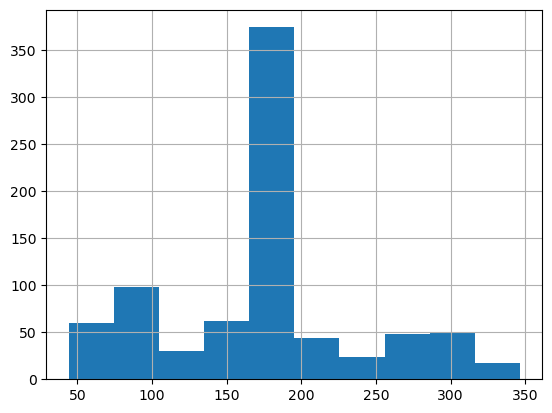

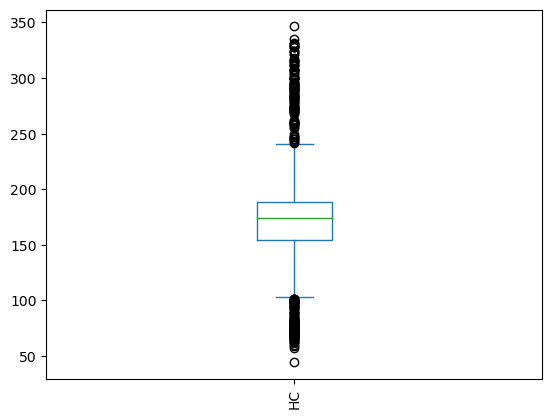

In [25]:
###### # plot a histogram  
HC_df['HC'].hist(bins=10)
columns = ['HC']
HC_df[columns].plot.box()
plt.xticks(rotation='vertical')

In [5]:
train_df.to_csv("C:/Users/ASUS/Downloads/Try_hats_dawg/B3/mlmed2025/Pratical_2/1327317/train_file.csv", index=False, encoding='utf8')

valid_df.to_csv("C:/Users/ASUS/Downloads/Try_hats_dawg/B3/mlmed2025/Pratical_2/1327317/val_file.csv", index=False, encoding='utf8')

test_df.to_csv("C:/Users/ASUS/Downloads/Try_hats_dawg/B3/mlmed2025/Pratical_2/1327317/test_file.csv", index=False, encoding='utf8')

# custom HC18 datasetclass

In [6]:
# Image manipulations
from PIL import Image

class HC_18(Dataset):
    """Head circumference estimation dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.HC_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.HC_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.HC_df.iloc[idx, 0])
        image = Image.open(img_name)
        features = self.HC_df.loc[idx,'HC']
        
        if self.transform:
            image = self.transform(image)
        return image , torch.tensor(features / 346.4)


# Images Transformations

In [7]:
image_transforms = {
    # Train uses data augmentation
    'train':
        transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(size=img_size),
            transforms.RandomRotation(degrees=10),
            transforms.GaussianBlur(5),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size=cropped_img),  # Image net standards
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),

    # Validation does not use augmentation
    'val':
        transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(size=img_size),
            transforms.GaussianBlur(5),
            transforms.CenterCrop(size=cropped_img),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    # Test does not use augmentation
    'test':
        transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(size=img_size),
            transforms.GaussianBlur(5),
            transforms.CenterCrop(size=cropped_img),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])}

# Data Loader

In [8]:
train_filename='C:/Users/ASUS/Downloads/Try_hats_dawg/B3/mlmed2025/Pratical_2/1327317/train_file.csv'
val_filename='C:/Users/ASUS/Downloads/Try_hats_dawg/B3/mlmed2025/Pratical_2/1327317/val_file.csv'
test_filename='C:/Users/ASUS/Downloads/Try_hats_dawg/B3/mlmed2025/Pratical_2/1327317/test_file.csv'

data = {'train': HC_18(train_filename ,root_dir = root_dir,transform = image_transforms['train']),
        'val': HC_18(val_filename ,root_dir = root_dir,transform = image_transforms['val']),
        'test': HC_18(test_filename ,root_dir = root_dir,transform = image_transforms['test'])
       }

# Dataloader iterators
dataloaders ={
    'train': DataLoader(data['train'], batch_size=batch_size,shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size,shuffle=False),
    'test': DataLoader(data['test'], batch_size=len(test_df),shuffle=False)
}

# Model

In [10]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7')


n_inputs = model._fc.in_features
model._fc = nn.Sequential(
    nn.Linear(n_inputs, 1 , bias = True)   
)

#print(model)

if train_on_gpu:
    model = model.to('cuda')

#Load the saved state dictionary
model.load_state_dict(torch.load(save_file_name))

Loaded pretrained weights for efficientnet-b7


<All keys matched successfully>

# Training function

In [13]:
# --------------------------------------Training
def train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,max_epochs_stop=20,n_epochs=20,print_every=1):

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_max_acc = 0
    history = []
    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch...\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):
        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0
        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)
            # Loss and backpropagation of gradients
            loss = criterion(output, target.float())
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Track training progress
            print( f'Epoch: {epoch+1}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target.float())
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)
                    
                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                history.append([train_loss, valid_loss])
                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(f'\nEpoch: {epoch+1} \tTraining Loss: {train_loss:.4f} \t\tValidation Loss: {valid_loss:.4f}')

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(f'\nEarly Stopping! Total epochs: {epoch+1}. Best epoch: {best_epoch+1} with loss: {valid_loss_min:.2f}')
                        total_time = timer() - overall_start
                        print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(history,columns=['train_loss', 'valid_loss'])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(f'\nBest epoch: {best_epoch+1} with loss: {valid_loss_min:.2f}')
    print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch + 1):.2f} seconds per epoch.')
    # Format history
    history = pd.DataFrame(history,columns=['train_loss', 'valid_loss'])
    return model, history

# Loss Function and Optimizer

In [14]:
# --------------------------------------Optimizer
criterion = nn.L1Loss()  # MAE loss = L1 Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training

In [15]:
# --------------------------------------Training
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=earlyStop,
    n_epochs=epochsNo,
    print_every=1
)

history.to_csv("C:/Users/ASUS/Downloads/Try_hats_dawg/B3/mlmed2025/Pratical_2/1327317/history.csv", index=False, encoding='utf8')
print("history.csv saved")

Starting Training from Scratch...



C:\Users\ASUS\anaconda3\lib\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


C:\Users\ASUS\anaconda3\lib\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


C:\Users\ASUS\anaconda3\lib\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)



Epoch: 1 	Training Loss: 0.2917 		Validation Loss: 0.2946
Epoch: 2	100.00% complete. 373.40 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.2110 		Validation Loss: 0.1777
Epoch: 3	100.00% complete. 373.42 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.1904 		Validation Loss: 0.2096
Epoch: 4	100.00% complete. 372.89 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.1819 		Validation Loss: 0.2042
Epoch: 5	100.00% complete. 372.94 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.1746 		Validation Loss: 0.1613
Epoch: 6	100.00% complete. 374.56 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 0.1700 		Validation Loss: 0.1696
Epoch: 7	100.00% complete. 373.38 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.1656 		Validation Loss: 0.1547
Epoch: 8	100.00% complete. 372.88 seconds elapsed in epoch.
Epoch: 8 	Training Loss: 0.1656 		Validation Loss: 0.1483
Epoch: 9	100.00% complete. 372.95 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.1620 		Validation Loss: 0.13

Epoch: 70	100.00% complete. 372.83 seconds elapsed in epoch.
Epoch: 70 	Training Loss: 0.1379 		Validation Loss: 0.1104
Epoch: 71	100.00% complete. 372.79 seconds elapsed in epoch.
Epoch: 71 	Training Loss: 0.1387 		Validation Loss: 0.1115
Epoch: 72	100.00% complete. 372.86 seconds elapsed in epoch.
Epoch: 72 	Training Loss: 0.1379 		Validation Loss: 0.1094
Epoch: 73	100.00% complete. 372.90 seconds elapsed in epoch.
Epoch: 73 	Training Loss: 0.1365 		Validation Loss: 0.1095
Epoch: 74	100.00% complete. 372.86 seconds elapsed in epoch.
Epoch: 74 	Training Loss: 0.1376 		Validation Loss: 0.1100
Epoch: 75	100.00% complete. 372.88 seconds elapsed in epoch.
Epoch: 75 	Training Loss: 0.1380 		Validation Loss: 0.1098
Epoch: 76	100.00% complete. 372.83 seconds elapsed in epoch.
Epoch: 76 	Training Loss: 0.1362 		Validation Loss: 0.1091
Epoch: 77	100.00% complete. 372.82 seconds elapsed in epoch.
Epoch: 77 	Training Loss: 0.1384 		Validation Loss: 0.1097
Epoch: 78	100.00% complete. 372.86 secon

Text(0.5, 1.0, 'Training and Validation Losses')

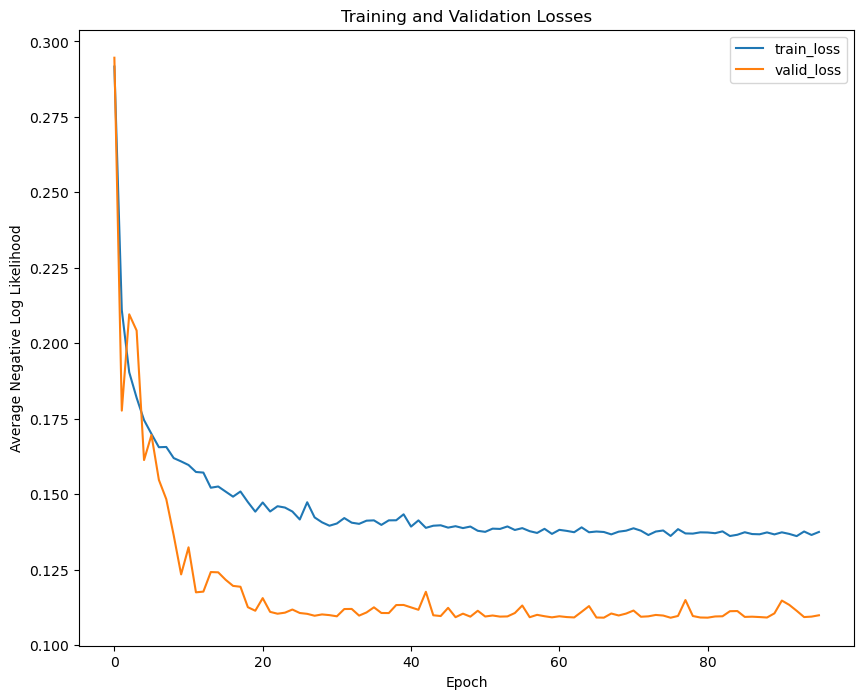

In [12]:
history = pd.read_csv("C:/Users/ASUS/Downloads/Try_hats_dawg/B3/mlmed2025/Pratical_2/1327317/history.csv")
plt.figure(figsize=(10, 8))
for c in ['train_loss', 'valid_loss']:
    plt.plot(history[c], label=c)
plt.legend()
plt.xlabel('Epoch',color='k')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

In [17]:
def save_checkpoint(model, path):

    # Basic details
    checkpoint = {
                'epochs': model.epochs
                 }

    # Extract the final classifier and the state dictionary
    checkpoint['fc'] = model._fc
    checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()
    # Save the data to the path
    torch.save(checkpoint, path)
    

In [18]:
save_checkpoint(model, path=checkpoint_path)

 # test the model


In [13]:
def check_mae_on_test(model, testloader, device='cpu'):
    """
    Compute the Mean Absolute Error (MAE) on the test dataset.

    Args:
        model: A pretrained model object.
        testloader: A generator object representing the test dataset.
        device: A string specifying whether to use cuda or cpu.

    Returns:
        std_mean: The standard deviation of the predicted head circumference.
        mae: The Mean Absolute Error of the predicted head circumference.
    """
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in testloader:
            if device == 'cuda':
                data, target = data.cuda(), target.cuda()
            output = model(data)
            all_predictions.extend(output.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())

    test_dataframe = pd.read_csv(test_filename)
    test_dataframe['predicted output'] = all_predictions
    test_dataframe['actual output'] = all_targets
    test_dataframe.to_csv("C:/Users/ASUS/Downloads/Try_hats_dawg/B3/mlmed2025/Pratical_2/1327317/pred_test_file.csv", index=False, encoding='utf8')

    std_mean = np.std(all_predictions)
    mae = np.mean(np.abs(np.array(all_predictions) - np.array(all_targets)))

    return std_mean, mae

In [15]:
std_mean, mae = check_mae_on_test(model, dataloaders['test'], device='cuda')
print('Test set MAE loss = {:.4f} '.format(mae))
print('Test set standard deviation of Hc = {:.4f} mm'.format(std_mean * 346.4))
print('Test set MAE loss of HC = {:.4f} mm'.format(mae * 346.4))

Test set MAE loss = 0.1266 
Test set standard deviation of Hc = 1.9322 mm
Test set MAE loss of HC = 43.8687 mm


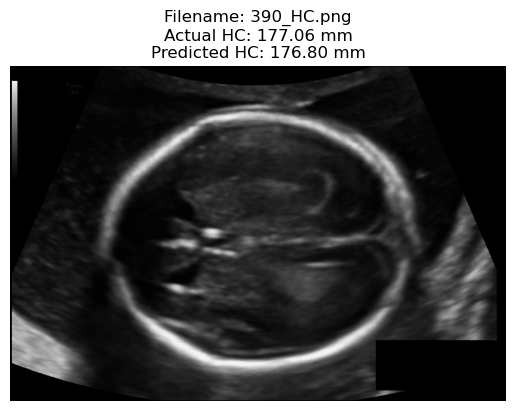

In [22]:

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_df = pd.read_csv(test_filename)
image_index = 3

filename = test_df.iloc[image_index, 0]
actual_hc = test_df.iloc[image_index, 2]

image_path = os.path.join(root_dir, filename)
image = Image.open(image_path).convert('RGB')

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=img_size),
    transforms.GaussianBlur(5),
    transforms.CenterCrop(size=cropped_img),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = test_transforms(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    prediction = model(input_tensor)
    predicted_hc_normalized = prediction.item()
    predicted_hc = predicted_hc_normalized * 346.4 # Reverse the normalization

plt.imshow(image)
plt.title(f"Filename: {filename}\nActual HC: {actual_hc:.2f} mm\nPredicted HC: {predicted_hc:.2f} mm")
plt.axis('off')
plt.show()

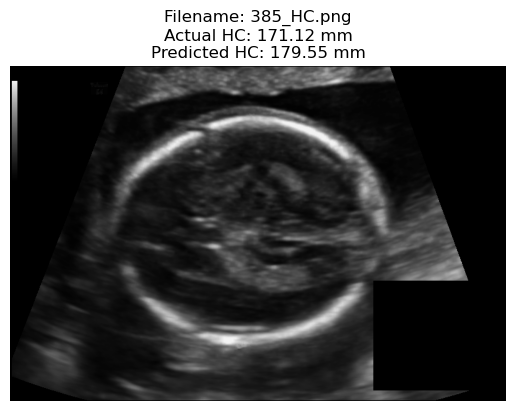

In [24]:

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_df = pd.read_csv(test_filename)
image_index = 

filename = test_df.iloc[image_index, 0]
actual_hc = test_df.iloc[image_index, 2]

image_path = os.path.join(root_dir, filename)
image = Image.open(image_path).convert('RGB')

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(size=img_size),
    transforms.GaussianBlur(5),
    transforms.CenterCrop(size=cropped_img),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = test_transforms(image).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    prediction = model(input_tensor)
    predicted_hc_normalized = prediction.item()
    predicted_hc = predicted_hc_normalized * 346.4 # Reverse the normalization

plt.imshow(image)
plt.title(f"Filename: {filename}\nActual HC: {actual_hc:.2f} mm\nPredicted HC: {predicted_hc:.2f} mm")
plt.axis('off')
plt.show()